In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

In [2]:
num_classes = 25
input_size = 28
sequence_size=28

num_layers = 2
hidden_size = 256

num_epochs = 5
learning_rate = 0.01
batch_size=64

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class ShuklaRNN(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes):
        super(ShuklaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, num_classes)
        
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:,1,:]

        out = self.fc1(out)
        return out

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=input_size, num_classes=num_classes):
        super(SimpleNN, self).__init__()
        
#         print(type(input_size))
        
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out
        
        

In [6]:
model = ShuklaRNN().to(device=device)

In [7]:
# testing
x = torch.randn(64,28,28).to(device=device)
# x = x.reshape(x.size(0), -1)
y = model(x)
print(y.shape)


torch.Size([64, 25])


In [8]:
import pandas as pd

df = pd.read_csv("../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")

df.iloc[:,1:].head().values 

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       [211, 211, 212, ..., 222, 229, 163],
       [164, 167, 170, ..., 163, 164, 179]])

In [9]:
import numpy as np
np.sort(df['label'].unique()), len(df['label'].unique())


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 24)

9th label is missing !

In [10]:
print(len(df), df.iloc[:,1:].head().values.shape)

27455 (5, 784)


In [11]:
class HandSignDataset(Dataset):
    def __init__(self, datapath):
        df = pd.read_csv(datapath)
        self.l = len(df)
        self.x = torch.from_numpy(df.iloc[:,1:].values)
#         print(type(self.x.size))
        self.x = self.x.reshape(self.x.size(0), 1, 28, 28).squeeze(1)
        self.x = self.x.squeeze()
        self.x = self.x.float()
        
        self.y = torch.from_numpy(df.iloc[:,0].values)
        self.y = self.y.long()
    
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.l
        

In [12]:
train_dataset = HandSignDataset("../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_dataset = HandSignDataset("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

train_dataloader = DataLoader(dataset=train_dataset, batch_size=64,shuffle=True )
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64,shuffle=True )

In [13]:
x,y = train_dataset[0]
x.shape, y.shape

(torch.Size([28, 28]), torch.Size([]))

In [14]:
import matplotlib.pyplot as plt

tensor(3)


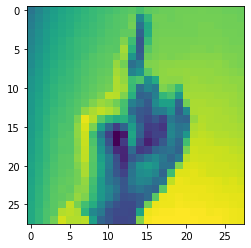

In [15]:
plt.imshow(x)
print(y)

In [16]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate  )

### for saving the data

In [17]:
def save_checkpoint(state,filename="my_checkpoint.pth.tar"):
    print(f"=> saving to {filename}")
    torch.save(state, filename)

In [18]:
def load_checkpoint(checkpoint):
    print(f"=> loading from checkpoint {checkpoint}")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    

In [27]:
load_model = False

In [28]:
## Loading checkpoint
if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"))

=> loading from checkpoint {'state_dict': OrderedDict([('lstm.weight_ih_l0', tensor([[ 0.0248,  0.0600,  0.0559,  ...,  0.1416,  0.0457,  0.0328],
        [ 0.0916,  0.0500,  0.0525,  ...,  0.0664,  0.0892,  0.0823],
        [-0.0746, -0.0168, -0.0862,  ..., -0.0174,  0.0015, -0.1109],
        ...,
        [ 0.0530,  0.0380,  0.1175,  ...,  0.0339,  0.0915,  0.0140],
        [-0.0218,  0.0006, -0.0424,  ..., -0.0288, -0.0202, -0.0126],
        [ 0.0466,  0.0394,  0.0322,  ...,  0.0582,  0.0434,  0.0439]],
       device='cuda:0')), ('lstm.weight_hh_l0', tensor([[ 0.0415, -0.0199,  0.0029,  ...,  0.0200,  0.0505,  0.0375],
        [-0.0572,  0.0576,  0.0178,  ..., -0.0239, -0.0308,  0.0197],
        [-0.0439, -0.0010, -0.0337,  ..., -0.0925,  0.0604, -0.0423],
        ...,
        [-0.0331, -0.0436,  0.0300,  ...,  0.0550,  0.0105, -0.0477],
        [ 0.0011, -0.0611,  0.0059,  ..., -0.0362, -0.0481, -0.0303],
        [-0.0310,  0.0107, -0.0524,  ...,  0.0243,  0.0430,  0.0368]],
       

In [29]:
# train loop

for epoch in range(num_epochs):
    
    if (epoch % 3 == 0):
        checkpoint = {'state_dict': model.state_dict(), 'optimizer':optimizer.state_dict()}
        save_checkpoint(checkpoint)
        
    for x, y in train_dataloader:
        
        x = x.reshape(x.size(0), 1, 28, 28).squeeze(1).to(device=device)
        y = y.to(device=device)
        
        pred = model(x)
        loss = loss_criterion(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    print(f"loss for epoch {epoch} : {loss}")

=> saving to my_checkpoint.pth.tar
loss for epoch 0 : 3.1743276119232178
loss for epoch 1 : 3.1785569190979004
loss for epoch 2 : 3.1595237255096436
=> saving to my_checkpoint.pth.tar
loss for epoch 3 : 3.1799213886260986
loss for epoch 4 : 3.1656782627105713


In [30]:
def check_accuracy(m, input_dataloader):
    total_sample = 0
    correct_sample = 0
    
    m.eval()
    
    with torch.no_grad():
        for x, y in input_dataloader:
            x = x.reshape(x.size(0), 1, 28, 28).squeeze(1).to(device=device)
            x = x.to(device=device)
            y = y.to(device=device)
            
            preds = m(x)
            _,predictions = preds.max(1)
            
            correct_sample = (y==predictions).sum()
            total_sample += predictions.size(0)
    m.train()
    
    print(f"out of total sample : {total_sample}  correct sample : {correct_sample} accuracy : {float(correct_sample/total_sample)*100:.2f}")
            

In [31]:
check_accuracy(model, train_dataloader)
check_accuracy(model, test_dataloader)

out of total sample : 27455  correct sample : 1 accuracy : 0.00
out of total sample : 7172  correct sample : 0 accuracy : 0.00


The reason for low accuracy seems to stem from the fact that label 9 is missing.
Any idea how to improve?